# Import Libs

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessing

In [188]:
# Import dataset
data = pd.read_excel('dataset_norm.xlsx')

# Define minimal mark
min_mark = 4

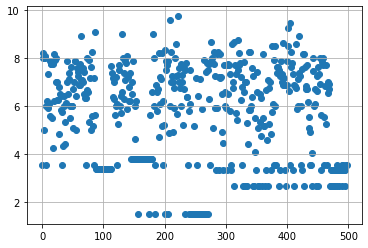

In [189]:
# Output distribution of scores
x = range(len(data['Средний балл']))
y = data['Средний балл']

plt.scatter(x, y)
plt.grid()
plt.show()

NOTE: lines in graph illustrate custom increase the number of not pass students.
That trick were done for better model training. It helps to increase accuracy metricks of models

Lets find out how many students did not pass the exams

In [190]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for mark in data['Средний балл']:
        if mark >= min_mark:
            passed += 1
        elif mark < min_mark:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")

counter_print()

TOTAL: 498
Passed: 341
Not pas: 157


In [191]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop(['Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)

Dataset with concern questions

In [192]:
data.head()

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,Кайнов Кирилл Анатольевич,Нет,"да, хожу на фитнес или в тренажерный зал",От 1 до 3 часов в день,Среднее количество пропусков,1-2 раза в семестр,нет,Нет,0
1,Матутин Василий Андреевич,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,"Нет, но собираюсь в этом году",1
2,Константинов Александр Михайлович,Да,"нет, не занимаюсь",Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,нет,Нет,1
3,Кудакаев Руслан Фаритович,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,Нет,1
4,Балов Илья Сергеевич,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,нет,Да,1


Split our data in 3 parts for train, test and validation

In [217]:
# Save hash of student name
name_hash = []


def train_test_val_split(test_ratio, validation_ratio):
# That part index all names to use them in validation part
    global name_hash
    for idx, name in enumerate(data['Учащийся']):
        name_hash.append((idx, name))
        data.loc[idx:,0] = idx  # data['Учащийся'][idx] = idx


# Replace all text output to index
    label_encoder = LabelEncoder()
    s = (data.dtypes == 'object')
    object_cols = list(s[s].index)
    label_data = data.copy()
    for col in object_cols:
        label_encoder.fit(data[col])
        label_data[col] = label_encoder.transform(data[col])

# Split dataset
# NOTE: To fix split selections use random_state=42 parameter
    size = data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))

    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio)

    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                      y_train, 
                                                      test_size=validation_ratio)

# Output X_train.iloc[:,1:] delete student hash from training and testing selections
    return X_train.iloc[:,1:], X_test.iloc[:,1:], X_val, y_train, y_test, y_val

In [220]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.01)

In [221]:
X_val

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,0
203,99,1,3,8,0,3,7,0,203
463,30,1,16,1,0,3,1,1,463
238,125,1,14,9,2,1,7,1,238
2,156,0,20,8,1,2,7,1,2
126,294,1,20,9,0,3,7,0,126


# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [222]:
def classification_quality(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:", (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [223]:
# For historical reason
def regression_quality(y_test, y_pred):
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

In [224]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # Classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for _ in range(4): temp_array.append(None)
    
    # For historical reason
    elif model_flag == 'reg': # Regression
        return
        for _ in range(5): temp_array.append(None)
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for _ in range(len(metrics_list)): temp_array.append(None)

    model_indx = -1
    flag = 1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [225]:
def graph_show(model, X, y):
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)  
    plt.show()

## Classifier

### Perception Classifier Model

In [226]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')

Accuracy: 0.68
Recall: 0.5066176470588235
Precision: 0.5914634146341464
F1: 0.4276556776556776
Weighted Recall: (0.5914634146341464, 0.5066176470588235, 0.4276556776556776, None)


### Random Forest Classifier Model

In [227]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')

Accuracy: 0.984
Recall: 0.9882352941176471
Precision: 0.9761904761904762
F1: 0.9818524970963995
Weighted Recall: (0.9761904761904762, 0.9882352941176471, 0.9818524970963995, None)


### Gradient Boosting Classifier Model

In [228]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 0.96
Recall: 0.9705882352941176
Precision: 0.9444444444444444
F1: 0.9554367201426025
Weighted Recall: (0.9444444444444444, 0.9705882352941176, 0.9554367201426025, None)


### MultinomialNB Classifier Model

In [229]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.648
Recall: 0.6419117647058823
Precision: 0.62584767866458
F1: 0.6249318057828697
Weighted Recall: (0.62584767866458, 0.6419117647058823, 0.6249318057828697, None)


### ComplementNB Classifier Model

In [230]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.648
Recall: 0.6485294117647059
Precision: 0.6306935817805384
F1: 0.6279761904761906
Weighted Recall: (0.6306935817805384, 0.6485294117647059, 0.6279761904761906, None)


### GaussianNB Classifier Model

In [231]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.92
Recall: 0.9411764705882353
Precision: 0.9
F1: 0.9131944444444444
Weighted Recall: (0.9, 0.9411764705882353, 0.9131944444444444, None)


### BernoulliNB Classifier Model

In [232]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.88
Recall: 0.9117647058823529
Precision: 0.8636363636363636
F1: 0.8726655348047538
Weighted Recall: (0.8636363636363636, 0.9117647058823529, 0.8726655348047538, None)


### SVC Classifier Model

In [233]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.68
Recall: 0.5
Precision: 0.34
F1: 0.8095238095238095
Weighted Recall: (0.34, 0.5, 0.40476190476190477, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LinearSVC Classifier Model

In [234]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.448
Recall: 0.5941176470588235
Precision: 0.6834862385321101
F1: 0.42687221742308457
Weighted Recall: (0.6834862385321101, 0.5941176470588235, 0.42687221742308457, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### DecisionTreeClassifier Model

In [235]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.976
Recall: 0.9823529411764707
Precision: 0.9651162790697674
F1: 0.9729456749152298
Weighted Recall: (0.9651162790697674, 0.9823529411764707, 0.9729456749152298, None)


### ExtraTreeClassifier Model

Accuracy: 0.968
Recall: 0.9764705882352941
Precision: 0.9545454545454546
F1: 0.9641422834193918
Weighted Recall: (0.9545454545454546, 0.9764705882352941, 0.9641422834193918, None)


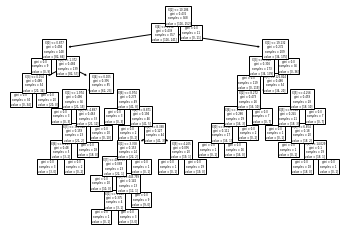

In [236]:
from sklearn.tree import plot_tree, ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

plot_tree(extr)
classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

### MLPClassifier Model

In [237]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.952
Recall: 0.9647058823529412
Precision: 0.9347826086956521
F1: 0.9468235961429381
Weighted Recall: (0.9347826086956521, 0.9647058823529412, 0.9468235961429381, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Matrix
That table helps to understand which model is better for my work

In [238]:
pd.DataFrame(index=metrics_list, columns=model_array, data=np.array(pd.DataFrame(output_array).T))

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,BernoulliNB,SVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,MLPClassifier
Accuracy,0.68,0.984,0.96,0.648,0.648,0.92,0.88,0.68,0.448,0.976,0.968,0.952
Balanced Accuracy,0.506618,0.988235,0.970588,0.641912,0.648529,0.941176,0.911765,0.5,0.594118,0.982353,0.976471,0.964706
Recall,0.506618,0.988235,0.970588,0.641912,0.648529,0.941176,0.911765,0.5,0.594118,0.982353,0.976471,0.964706
Precision,0.591463,0.97619,0.944444,0.625848,0.630694,0.9,0.863636,0.34,0.683486,0.965116,0.954545,0.934783
F1,0.427656,0.981852,0.955437,0.624932,0.627976,0.913194,0.872666,0.809524,0.426872,0.972946,0.964142,0.946824
MSE,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None


# Model result

I decided to use model X due to its metrix

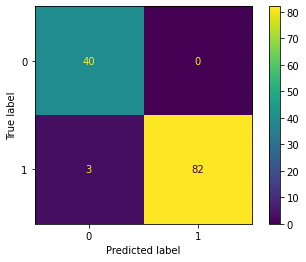

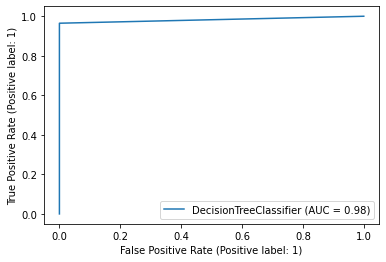

In [239]:
my_model = dtr

# ROC/AUC graphs
graph_show(my_model, X_test, y_test)

# Validation

In [240]:
# Get predicted results of validation selection
# NOTE: Validation selection was not used for training model thus the results are objective
y_pred_val = my_model.predict(X_val.iloc[:,1:])

In [241]:
error_counter = 0
total = 0
for i in range(len(y_pred_val)):
    if y_pred_val[i] != y_val.iloc[i] == 1:
        error_counter += 1
    total += 1
    print(f'Студент {name_hash[X_val.iloc[i, 0]][1]} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')
print(f'There were {error_counter} from {total} error(s)!')

Студент Мещерин Антон Андреевич предположительно сдал(а), в жизни сдал(а)
Студент Гаврилина Дарья Александровна предположительно сдал(а), в жизни сдал(а)
Студент Палашинович Анна Ивановна предположительно не сдал(а), в жизни не сдал(а)
Студент Бахметьева-Войникович Тамара Борисовна предположительно сдал(а), в жизни сдал(а)
Студент Огурлиев Анзор Амербиевич предположительно сдал(а), в жизни сдал(а)
There were 0 from 5 error(s)!
